# Classifying SNe

`Authors: Carolina Núñez, Vicente Pedreros, Antonio Vitalic`

The Dark Energy Science Collaboration released a new dataset with simulated light curves from LSST, including many classes of transient and persistent sources, including light curves and host information: [training set](https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/#trainingset)

In this project you are asked to build a classifier that can discriminate between the three classes of SNe: SNII (SNII-Templates, SNII-HostXT_V19 and SNII-NMF), SNIa (SNIa-91bg, SNIa-SALT2 and SNIax) and SNIbc (SNIb+HostXT_V19, SNIb-Templates, SNIc+HostXT_V19, SNIc-Templates, SNIcBL+HostXT_V19).
You can use metadata and light curve information.


Basic libraries are imported. Note that `Table` is used to transform the fits files to a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import fnmatch, glob

# from google.colab import drive
# drive.mount('/content/drive/')

# Display all columns of pandas dataframe
pd.set_option('display.max_columns', None)

In [2]:
colors = {'u': 'b', 'g': 'g', 'r': 'r', 'i': 'orange', 'z': 'brown', 'Y': 'k'}

## Curating the data

The first thing to do is import the data. The function `to_df` will recieve the path to the first model of each class and return a dataframe. Note that the columns that will be used to classification are in the list `alert_name`.

In [3]:
head_filenames = fnmatch.filter(glob.glob('data_rn/*'), '*HEAD.FITS.gz')
# These are the classes that will be classified
classes = ['SNIa', 'SNIbc', 'SNII']

# The following columns are the ones that will be used for classification
alert_name = ['SNID', 'RA', 'DEC', 'NOBS', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_SPECZ',
              'HOSTGAL_SPECZ_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_ZPHOT_Q000', 'HOSTGAL_ZPHOT_Q010', 'HOSTGAL_ZPHOT_Q020', 'HOSTGAL_ZPHOT_Q030',
              'HOSTGAL_ZPHOT_Q040', 'HOSTGAL_ZPHOT_Q050', 'HOSTGAL_ZPHOT_Q060', 'HOSTGAL_ZPHOT_Q070', 'HOSTGAL_ZPHOT_Q080', 'HOSTGAL_ZPHOT_Q090', 'HOSTGAL_ZPHOT_Q100',
              'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
              'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y', 'HOSTGAL2_RA', 'HOSTGAL2_DEC', 'HOSTGAL2_SNSEP', 'HOSTGAL2_SPECZ', 'HOSTGAL2_SPECZ_ERR', 'HOSTGAL2_PHOTOZ',
              'HOSTGAL2_PHOTOZ_ERR', 'HOSTGAL2_ZPHOT_Q000', 'HOSTGAL2_ZPHOT_Q010', 'HOSTGAL2_ZPHOT_Q020', 'HOSTGAL2_ZPHOT_Q030',  'HOSTGAL2_ZPHOT_Q040', 'HOSTGAL2_ZPHOT_Q050',
              'HOSTGAL2_ZPHOT_Q060', 'HOSTGAL2_ZPHOT_Q070', 'HOSTGAL2_ZPHOT_Q080', 'HOSTGAL2_ZPHOT_Q090', 'HOSTGAL2_ZPHOT_Q100', 'HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g',
              'HOSTGAL2_MAG_r', 'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y', 'HOSTGAL2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r', 'HOSTGAL2_MAGERR_i',
              'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']

In [4]:
def to_df(filename):
    """
    This function recieves a filename and will create a dataframe by using the HEAD's and PHOT's files.
    The columns corresponding to simulation information are droppped.
    """
    df_train = Table.read(filename, format='fits').to_pandas()
    for col in ['SNID', 'IAUC', 'SIM_MODEL_NAME', 'SIM_TYPE_NAME']:
        df_train[col] = df_train[col].apply(
            lambda row: row.decode("utf-8").strip())

    df_lc = Table.read(filename.replace("HEAD", "PHOT"),
                       format='fits').to_pandas()
    for col in ['BAND', 'FIELD']:
        df_lc[col] = df_lc[col].apply(lambda row: row.decode("utf-8").strip())

    # The data from HEAD and PHOT are grouped.
    df = df_train.groupby("SNID").apply(
        lambda df: df_lc.iloc[df.PTROBS_MIN.iloc[0]-1:df.PTROBS_MAX.iloc[0]-1]).reset_index()
    df = pd.merge(df_train, df, left_on='SNID', right_on='SNID')

    # Only alert_name columns are considered
    df = df[alert_name]

    subclass = filename.replace('_HEAD.FITS.gz', '').replace(
        'data_rn/', '')  # Name of the subclass
    # List of strings containing the name of the subclass
    subclasses = [subclass for x in range(len(df))]

    _class_ = subclass[:4]  # Name of the class
    # List of strings containing the name of the class
    classes = [_class_ for x in range(len(df))]

    # A column containing the class and subclass are added
    df.insert(0, 'SUBCLASS', subclasses)
    df.insert(0, 'CLASS', classes)
    df.replace(['SNIb', 'SNIc'], 'SNIbc', inplace=True)

    return df

In [5]:
dataframes = [to_df(filename) for filename in head_filenames]

df_train = pd.concat(dataframes)
df_train

,CLASS,SUBCLASS,SNID,RA,DEC,NOBS,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR
0,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60442.4130,i,-1.563279,11.344539
1,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60444.4280,r,3.731861,4.645030
2,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60457.4187,Y,-17.873014,42.014057
3,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60457.4293,z,12.042594,25.301315
4,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.3

In [6]:
# First, objects with less than 70 observations are dropped
df_train2 = df_train.copy()
df_train2.drop(df_train2[df_train2.NOBS < 70].index, inplace=True)

In [7]:
# Roughly 5000 elements are dropped
print(len(df_train.SNID.unique()))
print(len(df_train2.SNID.unique()))

23642
18823


In [8]:
df = df_train2[['SNID', 'CLASS', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']].copy()
df.MJD = df.MJD.round(0).astype(int)
df

,SNID,CLASS,MJD,BAND,FLUXCAL,FLUXCALERR
33,31254142,SNII,60550,u,-18.278835,8.333675
34,31254142,SNII,60550,r,3.481718,3.379142
35,31254142,SNII,60550,i,2.467680,6.355485
36,31254142,SNII,60553,u,23.797745,10.453723
37,31254142,SNII,60553,g,-0.527714,3.756804
...,...,...,...,...,...,...
118810,15480123,SNIbc,60961,i,-10.518693,8.376203
118811,15480123,SNIbc,60961,z,8.501602,15.873994
118812,15480123,SNIbc,60967,r,1.206127,3.369061
118813,15480123,SNIbc,60967,i,-8.784276,3.759806


## Visualization of data

A count plot, 20 lightcurves per class and histograms are presented.

In [ ]:
ax = df.groupby('SNID').max().CLASS.value_counts().plot.bar()

In [59]:
def plot_lc(SNID, df, path=None):
    """
    Plots the lightcurves, generating a lightcurve (lc) for each band, but it shows
    all bands in one figure.
    """
    fig, ax = plt.subplots(figsize=(8, 3))
    for idx, c in enumerate(colors.keys()):
        mask = (df.SNID == str(SNID)) & (df.BAND == c)
        if mask.sum() > 0:
            ax.errorbar(df.loc[mask].MJD, df.loc[mask].FLUXCAL,
                        yerr=df.loc[mask].FLUXCALERR, color=list(colors.values())[idx], fmt='o', ms=3, lw=0, elinewidth=1, label=c)

    ax.set_xlabel('mjd')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_title(str(SNID) + ' ' + df.loc[mask].iloc[0].CLASS)
    if path is not None:
        fig.savefig(path+'lc_'+SNID+'.png')

In [ ]:
np.random.seed(73)

snids_20sample = [list(df.loc[df.CLASS.isin([df.CLASS.unique()[i]])].sample(
    20).SNID) for i in range(len(df.CLASS.unique()))]

snids_20 = sum(snids_20sample, [])

In [ ]:
for snid in snids_20:
    plot_lc(str(snid), df, path='images/lightcurves/')
    plt.show()

In [ ]:
# Histograma de flujos de todos los datos
counts, bins = np.histogram(
    df.FLUXCAL.to_numpy(), bins=100, range=(-200, 200))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Flux histogram')

In [ ]:
# Flux Error Histogram
counts, bins = np.histogram(
    df.FLUXCALERR.to_numpy(), bins=50, range=(0, 100))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Flux error histogram')

In [ ]:
# SNR Histogram
counts, bins = np.histogram(df.FLUXCAL.to_numpy(
)/df.FLUXCALERR.to_numpy(), bins=50, range=(0, 30))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Signal to noise ratio histogram')

In [ ]:
# Number of observations Histogram

fig, ax = plt.subplots()
for c in list(colors.keys()):
    counts, bins = np.histogram(
        df_train.loc[df_train.BAND == c].NOBS.to_numpy(), bins=100)
    ax.hist(bins[:-1], bins, weights=counts, alpha=0.3)
plt.title('Number of observations histogram')

## Preprocessing 

In [9]:
# Dataframe containing day of peak in flux, for each object

flux_max = df.groupby('SNID').FLUXCAL.idxmax()
df_maxflux = df.iloc[flux_max].reset_index(drop=True)
df_maxflux

,SNID,CLASS,MJD,BAND,FLUXCAL,FLUXCALERR
223996,27124538,SNII,61262,r,1.569316,4.780828
171309,57851624,SNII,61109,g,-2.251027,2.625165
5772,84824269,SNII,61007,Y,22.019747,31.967005
48896,81144259,SNIa,60736,i,2.062272,6.241243
85057,199501,SNII,60754,z,9.297605,10.442643
...,...,...,...,...,...,...
126558,13269752,SNII,60966,i,-1.371374,6.341302
46216,21579324,SNII,60973,r,0.916617,3.632852
292769,11205412,SNII,60730,u,-2.643732,7.294426
270507,22128600,SNII,61095,r,-7.157457,3.901012


In [12]:
flux_max = df.groupby('SNID').FLUXCAL.idxmax()
df_maxflux = df.iloc[flux_max]

# Pivot Table

In [13]:
df_pivot = pd.pivot_table(df, values=['FLUXCAL', 'FLUXCALERR'], index=['SNID','CLASS', 'MJD'], columns=['BAND'])
#df_pivot.reset_index(inplace=True)
df_pivot

FLUXCAL                                           \
BAND                          Y          g          i   r   u          z   
SNID     CLASS MJD                                                         
10008157 SNII  60880        NaN        NaN   8.847892 NaN NaN        NaN   
               60894  19.283108        NaN        NaN NaN NaN        NaN   
               60896 -25.441965        NaN        NaN NaN NaN  14.744574   
               60897  47.578812        NaN        NaN NaN NaN        NaN   
               60993        NaN  47.322262        NaN NaN NaN        NaN   
...                         ...        ...        ...  ..  ..        ...   
998967   SNIbc 60749  46.768677        NaN        NaN NaN NaN        NaN   
               60751 -10.907286        NaN        NaN NaN NaN  55.427319   
               61125 -11.775251        NaN        NaN NaN NaN -24.773096   
               61128        NaN        NaN  -9.718035 NaN NaN        NaN   
               61129        NaN        NaN  13.574255 NaN NaN        NaN   

                     FLUXCALERR                                          
BAND                          Y         g          i   r   u          z  
SNID     CLASS MJD                                                       
10008157 SNII  60880        NaN       NaN   9.405591 NaN NaN        NaN  
               60894  17.621897       NaN        NaN NaN NaN        NaN  
               60896  38.738998       NaN        NaN NaN NaN  13.915695  
               60897  40.035275       NaN        NaN NaN NaN        NaN  
               60993        NaN  3.183366        NaN NaN NaN        NaN  
...                         ...       ...        ...  ..  ..        ...  
998967   SNIbc 60749  25.626047       NaN        NaN NaN NaN        NaN  
               60751  30.457952       NaN        NaN NaN NaN  19.804647  
               61125  23.805344       NaN        NaN NaN NaN  11.694359  
               61128        NaN       NaN   9.448407 NaN NaN        NaN  
               61129        NaN       NaN  10.842972 NaN NaN        NaN  

[784540 rows x 12 columns]

In [14]:
df_pivot.columns = df_pivot.columns.droplevel(0)
df_pivot = df_pivot.reset_index().rename_axis(None, axis=1)

In [15]:
cols_f = ['F_Y', 'F_g', 'F_i', 'F_r', 'F_u', 'F_z']
cols_err = ['E_Y', 'E_g', 'E_i', 'E_r', 'E_u', 'E_z']

col = np.concatenate([cols_f, cols_err])
col

array(['F_Y', 'F_g', 'F_i', 'F_r', 'F_u', 'F_z', 'E_Y', 'E_g', 'E_i',
       'E_r', 'E_u', 'E_z'], dtype='<U3')

In [16]:
u = ['SNID', 'CLASS', 'MJD']
df_pivot.columns = np.concatenate([u, col])

In [17]:
df_pivot

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
0,10008157,SNII,60880,NaN,NaN,8.847892,NaN,NaN,NaN,NaN,NaN,9.405591,NaN,NaN,NaN
1,10008157,SNII,60894,19.283108,NaN,NaN,NaN,NaN,NaN,17.621897,NaN,NaN,NaN,NaN,NaN
2,10008157,SNII,60896,-25.441965,NaN,NaN,NaN,NaN,14.744574,38.738998,NaN,NaN,NaN,NaN,13.915695
3,10008157,SNII,60897,47.578812,NaN,NaN,NaN,NaN,NaN,40.035275,NaN,NaN,NaN,NaN,NaN
4,10008157,SNII,60993,NaN,47.322262,NaN,NaN,NaN,NaN,NaN,3.183366,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784535,998967,SNIbc,60749,46.768677,NaN,NaN,NaN,NaN,NaN,25.626047,NaN,NaN,NaN,NaN,NaN
784536,998967,SNIbc,60751,-10.907286,NaN,NaN,NaN,NaN,55.427319,30.457952,NaN,NaN,NaN,NaN,19.804647
784537,998967,SNIbc,61125,-11.775251,NaN,NaN,NaN,NaN,-24.773096,23.805344,NaN,NaN,NaN,NaN,11.694359
784538,998967,SNIbc,61128,NaN,NaN,-9.718035,NaN,NaN,NaN,NaN,NaN,9.448407,NaN,NaN,NaN


In [17]:
df_pivot.interpolate(limit=20, limit_direction='both', inplace=True)

In [18]:
df_pivot

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
0,10008157,SNII,60880,19.283108,47.322262,8.847892,43.820179,8.475088,14.744574,17.621897,3.183366,9.405591,3.892100,7.261147,13.915695
1,10008157,SNII,60894,19.283108,47.322262,11.804519,43.820179,8.475088,14.744574,17.621897,3.183366,9.104545,3.892100,7.261147,13.915695
2,10008157,SNII,60896,-25.441965,47.322262,14.761145,43.820179,8.475088,14.744574,38.738998,3.183366,8.803499,3.892100,7.261147,13.915695
3,10008157,SNII,60897,47.578812,47.322262,17.717772,43.820179,8.475088,18.698460,40.035275,3.183366,8.502453,3.892100,7.261147,12.992152
4,10008157,SNII,60993,45.689995,47.322262,20.674398,43.820179,8.475088,22.652346,33.018658,3.183366,8.201406,3.892100,7.261147,12.068609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784535,998967,SNIbc,60749,46.768677,0.203340,3.805365,2.899909,8.444137,29.079414,25.626047,2.984699,7.531844,3.665793,6.899340,15.375885
784536,998967,SNIbc,60751,-10.907286,0.203340,-0.702435,2.899909,8.444137,55.427319,30.457952,2.984699,8.170698,3.665793,6.899340,19.804647
784537,998967,SNIbc,61125,-11.775251,0.203340,-5.210235,2.899909,8.444137,-24.773096,23.805344,2.984699,8.809553,3.665793,6.899340,11.694359
784538,998967,SNIbc,61128,-11.775251,0.203340,-9.718035,2.899909,8.444137,-24.773096,23.805344,2.984699,9.448407,3.665793,6.899340,11.694359


In [19]:
print('Y: ',np.sum(np.isnan(df_pivot.F_Y)))
print('g: ',np.sum(np.isnan(df_pivot.F_g)))
print('i: ',np.sum(np.isnan(df_pivot.F_i))) # Banda con la menor cant de Nan
print('r: ',np.sum(np.isnan(df_pivot.F_r)))
print('u: ',np.sum(np.isnan(df_pivot.F_u)))
print('z: ', np.sum(np.isnan(df_pivot.F_z)))

Y:  0
g:  127
i:  0
r:  0
u:  4353
z:  0


In [20]:
snids = df_pivot.SNID.unique()
corte = df_pivot.groupby('SNID').F_i.max().to_numpy()
corte

array([35.45753 , 43.904636,  9.818868, ..., 15.835579, 40.58201 ,
       27.305063], dtype=float32)

In [21]:
print(len(snids))
print(len(corte))


18823
18823


In [22]:
# Busco el MJD donde está el max  -> corto los anteriores + Los que estén después de 200 MJD
# Plot lc para chequear los max y si está bien el corte (no se pierde info)

u = df_pivot.loc[(df_pivot.SNID == snids[0]) & (df_pivot.F_i == corte[0])].MJD.to_numpy()[0]
u

61016

In [23]:
df_pivot.F_i.fillna(0)

0          8.847892
1         11.804519
2         14.761145
3         17.717772
4         20.674398
            ...    
784535     3.805365
784536    -0.702435
784537    -5.210235
784538    -9.718035
784539    13.574255
Name: F_i, Length: 784540, dtype: float32

In [24]:
corte_mjd = []
for i in range(len(snids)):
  mask = (df_pivot.SNID == snids[i]) & (df_pivot.F_i == corte[i])
  if mask.sum() > 0:
    corte_mjd.append(df_pivot.loc[mask].MJD.to_numpy()[0])
  else:
    df_pivot.drop(df_pivot[df_pivot.SNID == snids[i]].index, inplace=True)

In [25]:
corte_mjd = np.array(corte_mjd)
corte_mjd

array([61016, 60903, 60769, ..., 61197, 61164, 60622])

In [26]:
snids = df_pivot.SNID.unique()

In [27]:
for idx, snid  in enumerate(snids):
    mask = df_pivot.SNID == snid
    below_mjd = df_pivot.MJD < corte_mjd[idx]
    above_mjd = df_pivot.MJD > (corte_mjd[idx] + 200)

    df_pivot.drop(df_pivot[below_mjd].loc[mask].index, inplace=True)
    df_pivot.drop(df_pivot[above_mjd].loc[mask].index, inplace=True)

/tmp/ipykernel_4709/2950909285.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pivot.drop(df_pivot[above_mjd].loc[mask].index, inplace=True)


In [28]:
df_pivot_test = df_pivot.copy()

In [29]:
df_pivot_test

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
9,10008157,SNII,61016,58.764484,17.074627,35.457531,27.547527,14.229533,42.421776,17.941063,2.865665,6.696176,3.966271,5.572297,7.450893
10,10008157,SNII,61019,55.938835,11.823051,32.815418,22.123310,13.805165,51.396309,21.432184,2.963698,4.460186,3.990995,5.591389,12.383206
11,10008157,SNII,61032,53.113182,6.571475,31.836632,23.209131,13.380796,44.310875,24.923304,3.061730,6.758489,3.745010,5.610481,14.084270
12,10008157,SNII,61034,50.287533,0.850332,30.857847,6.040419,12.956428,37.225445,28.414425,2.999014,9.056792,5.826120,5.629574,15.785332
13,10008157,SNII,61042,47.461884,1.109434,29.879061,7.298099,12.532060,30.140011,31.905546,2.995402,11.355095,6.230913,5.648666,17.486395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784532,998967,SNIbc,60740,-22.081779,0.203340,18.391546,2.899909,8.444137,13.709175,29.884739,2.984699,6.015069,3.665793,6.899340,9.503990
784533,998967,SNIbc,60742,-24.322134,0.203340,13.352356,2.899909,8.444137,28.854258,31.093678,2.984699,6.454029,3.665793,6.899340,17.583939
784534,998967,SNIbc,60744,11.223271,0.203340,8.313165,2.899909,8.444137,2.731512,28.359863,2.984699,6.892989,3.665793,6.899340,10.947123
784535,998967,SNIbc,60749,46.768677,0.203340,3.805365,2.899909,8.444137,29.079414,25.626047,2.984699,7.531844,3.665793,6.899340,15.375885


In [30]:
# Agregar filas según cuantos dias pensemos usar -> Reemplazar nan = interpolar (en vez de las medianas)

In [157]:
# Desde la medición del peak de flujo en la banda i, hasta 200 dias después, en pasos de a 4.

min_mjd = df_pivot_test.groupby('SNID').min().MJD  # mínimo mjd para cada objeto

df_mjd = pd.DataFrame(min_mjd, columns=df_pivot.columns, dtype='float64').drop('SNID', axis=1).reset_index()  # df contiene minimo mjd y snid
df_mjd

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
0,10008157,NaN,61016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10010064,NaN,60903.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10014400,NaN,60769.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100149,NaN,61191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10017472,NaN,60815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18818,998406,NaN,60398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18819,9987542,NaN,61163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18820,9988895,NaN,61197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18821,9989413,NaN,61164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
# Each row is repeated 50 times
df_mjd = df_mjd.loc[df_mjd.index.repeat(50)]

In [159]:
# This is a dataframe containing numbers between 0 and 196, in steps of 4
# df_add = pd.DataFrame( np.linspace(0, 196, 50), columns=['MJD'])

for snid in snids:
    mask = df_mjd.SNID == snid
    df_mjd.loc[mask, 'MJD'] = df_mjd.loc[mask].MJD + np.linspace(0, 196, 50)

In [160]:
df_mjd.reset_index(inplace=True, drop=True)
df_mjd

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
0,10008157,NaN,61016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10008157,NaN,61020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10008157,NaN,61024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10008157,NaN,61028.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10008157,NaN,61032.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941145,998967,NaN,60802.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941146,998967,NaN,60806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941147,998967,NaN,60810.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941148,998967,NaN,60814.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [222]:
snid = snids[2]

df1 = df_mjd.loc[df_mjd.SNID == snid]
df2 = df_pivot.loc[df_pivot.SNID == snid]
for mjd in df2.MJD.to_numpy():
    if mjd not in df1.MJD.to_numpy():
        df2 = df2.drop(df2.loc[df2.MJD == mjd].index)
df_combined = df1.combine_first(df2)
df_combined = df_combined.drop_duplicates(subset='MJD', keep='last').sort_values('MJD')
df_combined = df_combined.interpolate(limit=20, limit_direction='both')

In [228]:
df.loc[df.SNID == snid]

,SNID,CLASS,MJD,BAND,FLUXCAL,FLUXCALERR,SNR
2365,10014400,SNII,60746,z,5.448914,9.192567,0.592752
2366,10014400,SNII,60747,Y,-9.281802,27.209230,0.341127
2367,10014400,SNII,60748,Y,1.406662,21.175720,0.066428
2368,10014400,SNII,60756,z,-18.446140,12.891586,1.430867
2369,10014400,SNII,60759,r,2.119357,3.587571,0.590750
2370,10014400,SNII,60760,i,-5.796357,9.408101,0.616103
2371,10014400,SNII,60762,g,-0.751818,3.188277,0.235807
2372,10014400,SNII,60762,r,8.827244,4.836746,1.825038
2373,10014400,SNII,60769,i,9.818868,10.887427,0.901854
2374,10014400,SNII,60769,z,20.525581,18.837925,1.089588


In [229]:
df_pivot.loc[df_pivot.SNID == snid]

,SNID,CLASS,MJD,F_Y,F_g,F_i,F_r,F_u,F_z,E_Y,E_g,E_i,E_r,E_u,E_z
70,10014400,SNII,60769,-10.103254,-0.674344,9.818868,7.261821,12.862013,20.525581,41.470470,3.193108,10.887427,4.610024,8.347612,18.837925
71,10014400,SNII,60772,-12.405238,-0.596870,-10.840446,5.696398,12.428379,-2.560971,45.529419,3.197939,7.832576,4.383304,8.354365,10.803021
72,10014400,SNII,60774,-14.707221,-0.519396,6.639567,4.130975,11.994745,4.701350,49.588371,3.202770,9.970366,4.156582,8.361118,11.771160
73,10014400,SNII,60783,-17.009205,-0.441922,4.372696,2.565552,11.561111,5.317114,53.647320,3.207601,9.675484,3.929861,8.367871,9.964071


In [227]:
corte_mjd[2]

60769

## Building images (attempt 6x50)


In [175]:
# Tain test sets
from sklearn.model_selection import train_test_split

snids_train, snids_test = train_test_split(snids, test_size=.4, random_state=1)

In [190]:
# Labels vectors, train and test

df_class = df_pivot[['SNID', 'CLASS']].groupby(['SNID']).max().reset_index()
df_class

y_train = df_class.loc[df_class.SNID.isin(snids_train)].CLASS
y_test = df_class.loc[df_class.SNID.isin(snids_test)].CLASS

In [185]:
imgs_flux_train = []
imgs_flux_test = []

imgs_fluxerr_train = []
imgs_fluxerr_test = []

for snid in snids:
    df1 = df_mjd.loc[df_mjd.SNID == snid]
    df2 = df_pivot.loc[df_pivot.SNID == snid]
    for mjd in df2.MJD.to_numpy():
        if mjd not in df1.MJD.to_numpy():
            df2 = df2.drop(df2.loc[df2.MJD == mjd].index)
    df_combined = df1.combine_first(df2)
    df_combined = df_combined.drop_duplicates(subset='MJD', keep='last').sort_values('MJD')
    df_combined = df_combined.interpolate(limit=10, limit_direction='both')
    
    if snid in snids_train:
        imgs_flux_train.append(df_combined[cols_f].to_numpy().astype(float))
        imgs_fluxerr_train.append(df_combined[cols_err].to_numpy().astype(float))
    elif snid in snids_test:
        imgs_flux_test.append(df_combined[cols_f].to_numpy().astype(float))
        imgs_fluxerr_test.append(df_combined[cols_err].to_numpy().astype(float))

In [186]:
for idx in range(len(imgs_flux_train)):
    imgs_flux_train[idx] = np.transpose(np.nan_to_num(imgs_flux_train[idx]))
    imgs_fluxerr_train[idx] = np.transpose(np.nan_to_num(imgs_fluxerr_train[idx]))


for idx in range(len(imgs_flux_test)):
    imgs_flux_test[idx] = np.transpose(np.nan_to_num(imgs_flux_test[idx]))
    imgs_fluxerr_test[idx] = np.transpose(np.nan_to_num(imgs_fluxerr_test[idx]))

In [187]:
# Merging images so we have a big array, containing the two images for all objects

# X_train.shape = (nobj, 6 ,50, 2)

X_train = np.zeros((len(imgs_flux_train), 6, 50, 2))
X_test = np.zeros((len(imgs_flux_test), 6, 50, 2))

for i in range(len(X_train)):
    for j in range(6):
        for k in range(50):
            X_train[i][j][k][0] = imgs_flux_train[i][j][k]
            X_train[i][j][k][1] = imgs_fluxerr_train[i][j][k]

for i in range(len(X_test)):
    for j in range(6):
        for k in range(50):
            X_test[i][j][k][0] = imgs_flux_test[i][j][k]
            X_test[i][j][k][1] = imgs_fluxerr_test[i][j][k]

In [193]:
imgs = {'X_train': X_train, 'X_test': X_test, 'y_test': y_test, 'y_train': y_train}

# Saving the arrays. Note that the reshape is done since a 3D array can't be stored

for img in imgs.keys():
    try:
        np.savetxt(img + '.csv', imgs[img].reshape(imgs[img].shape[0], -1))
    except:
        np.savetxt(img + '.csv', imgs[img], fmt='%s')

In [205]:
imgs_flux_train[234]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

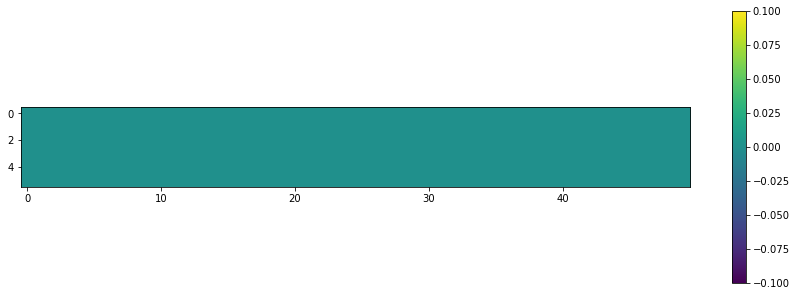

In [201]:
# x_test = np.nan_to_num(flux)

plt.figure(figsize=(15,5))
plt.imshow(imgs_flux_train[345])
plt.colorbar()


## Building images

The goal of this section is to build images so a Neural Network can perform classification.

Images of 6 x 30 will be built for each object. Each row corresponds to a band and each column to an observation. In the case that an aobject has more than 30 observations, only the first 30 are considered.

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df.BAND = encoder.fit_transform(df.BAND)

color = np.sort(df.BAND.unique())
color

To split the data into training and test sets, the fact that the dataframe contains multiple rows for an object needs to be considered. So, the array containing the SNID's (`snids_array`) will be splitted into a train and test array.

In [ ]:
from sklearn.model_selection import train_test_split

snids = df.SNID.unique()

snids_train, snids_test = train_test_split(
    snids, test_size=0.4, random_state=1)

To build the label vectors $(y)$, a new dataframe called df_class is created, which contains the class corresponding to the object

In [ ]:
df_class = df[['SNID', 'CLASS']].groupby(['SNID']).max().reset_index()
df_class

In [ ]:
# X "dataframe" train and test sets
X_df_train = df.loc[df.SNID.isin(
    snids_train)].drop('CLASS', axis=1)
X_df_test = df.loc[df.SNID.isin(
    snids_test)].drop('CLASS', axis=1)

# Labels vectors train and test
y_train = df_class.loc[df_class.SNID.isin(snids_train)].CLASS
y_test = df_class.loc[df_class.SNID.isin(snids_test)].CLASS

# Label encoder for the labels vectors
le = LabelEncoder()
yt_train = le.fit_transform(y_train)
yt_test = le.fit_transform(y_test)

It's REALLY important to note this difference. In the future 23642 images will be built.

In [ ]:
print('Total elements in X_df: ', len(X_df_train) + len(X_df_test), '\n', 'Total elements in y: ', len(y_train) + len(y_test))

Images are built. The training set takes around 150m, while the test 100m. The images are stored as csv files and to load them see the Loading images section.

In [ ]:
X_train_time = np.zeros((len(snids_train), 6, 30))
X_train_flux = np.zeros((len(snids_train), 6, 30))
X_train_fluxerr = np.zeros((len(snids_train), 6, 30))

for i in range(len(snids_train)):
    for c in color:
        mask = (df.SNID == snids_train[i]) & (df.BAND == c)
        df_mask = df.loc[mask]

        times = df_mask.MJD.to_numpy()
        flux = df_mask.FLUXCAL.to_numpy()
        fluxerr = df_mask.FLUXCALERR.to_numpy()

        out_time = np.zeros(30)
        out_time[:len(times)] = times[:30]
        out_flux = np.zeros(30)
        out_flux[:len(flux)] = flux[:30]
        out_fluxerr = np.zeros(30)
        out_fluxerr[:len(fluxerr)] = fluxerr[:30]

        X_train_time[i][c] = out_time
        X_train_flux[i][c] = out_flux
        X_train_fluxerr[i][c] = out_fluxerr

In [ ]:
X_test_time = np.zeros((len(snids_test), 6, 30))
X_test_flux = np.zeros((len(snids_test), 6, 30))
X_test_fluxerr = np.zeros((len(snids_test), 6, 30))

for i in range(len(snids_test)):
    for c in color:
        mask = (df.SNID == snids_test[i]) & (df.BAND == c)
        df_mask = df.loc[mask]

        times = df_mask.MJD.to_numpy()
        flux = df_mask.FLUXCAL.to_numpy()
        fluxerr = df_mask.FLUXCALERR.to_numpy()

        out_time = np.zeros(30)
        out_time[:len(times)] = times[:30]
        out_flux = np.zeros(30)
        out_flux[:len(flux)] = flux[:30]
        out_fluxerr = np.zeros(30)
        out_fluxerr[:len(fluxerr)] = fluxerr[:30]

        X_test_time[i][c] = out_time
        X_test_flux[i][c] = out_flux
        X_test_fluxerr[i][c] = out_fluxerr

In [ ]:
imgs = {'time_train': X_train_time, 'flux_train': X_train_flux, 'fluxerr_train': X_train_fluxerr,
        'time_test': X_test_time, 'flux_test': X_test_flux, 'fluxerr_test': X_test_fluxerr,
        'y_test': y_test, 'y_train': y_train}

# Saving the arrays. Note that the reshape is done since a 3D array can't be stored

for img in imgs.keys():
    try:
        np.savetxt(img + '.csv', imgs[img].reshape(imgs[img].shape[0], -1))
    except:
        np.savetxt(img + '.csv', imgs[img], fmt='%s')

In [ ]:
# Saving the arrays. Note that the reshape is done since a 3D array can't be stored

for img in imgs.keys():
    try:
        np.savetxt(img + '.csv', imgs[img].reshape(imgs[img].shape[0], -1))
    except:
        np.savetxt(img + '.csv', imgs[img], fmt='%s')

The first ten images are presented

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(90, 60))

for i in range(10):
    for j in range(3):
        ax[i, 0].imshow(X_train_time[i])
        ax[i, 1].imshow(X_train_flux[i])
        ax[i, 2].imshow(X_train_fluxerr[i])


## Loading images

The next cell is to store the images in the dictionary `imgs_dict`

In [ ]:
imgs_name = ['time_train', 'flux_train', 'fluxerr_train', 'time_test', 'flux_test', 'fluxerr_test', 'y_test', 'y_train']

In [ ]:
# Loading the arrays
imgs_dict = {}
for idx, img in enumerate(imgs.keys()):
    if idx < 6:
        imgs_dict[img] = np.loadtxt(img+'.csv')
        imgs_dict[img] = imgs_dict[img].reshape(
            imgs_dict[img].shape[0], imgs_dict[img].shape[1] // 30, 30)
    else:
        imgs_dict[img] = np.loadtxt(img+'.csv', dtype='str')

#### Replacing zeros in the images

The median for each band will be replaced for the values that are 0.

In [ ]:
matrixes_list = ['time_train', 'flux_train', 'fluxerr_train', 'time_test', 'flux_test', 'fluxerr_test']

In [ ]:
for matrix in matrixes_list:
    for img in range(len(imgs_dict[matrix])):
        for row in imgs_dict[matrix][img]:
            median = np.median(row[row != 0])
            row[row == 0] = median

#### Checking "new" images

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(90, 60))

for i in range(10):
    for j in range(3):
        ax[i, j].imshow(imgs_dict[matrixes_list[j]][i])

In [ ]:
# Merging images so we have a big array, containing the three images for all objects
train_array = []

X_train = np.zeros((len(imgs_dict[matrixes_list[0]]), 6, 30, 3))
X_test = np.zeros((len(imgs_dict[matrixes_list[3]]), 6, 30, 3))

for i in range(len(imgs_dict[matrixes_list[0]])):
  for j in range(6):
    for k in range(30):
      for l in range(3):
          X_train[i][j][k][l] = imgs_dict[matrixes_list[l]][i][j][k]

for i in range(len(imgs_dict[matrixes_list[3]])):
  for j in range(6):
    for k in range(30):
      for l in range(3):
          X_test[i][j][k][l] = imgs_dict[matrixes_list[l+3]][i][j][k]